# Phase 4 project

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix


nltk.download('wordnet')


plt.style.use('ggplot')
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [4]:
## First look at the data
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Change the column names so it can be more readable
data.columns = ['tweet', 'product', 'sentiment']

In [6]:
## Much cleaner
data.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
## Quick look at our target values
data.sentiment.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [8]:
## Change it so its now positive, negative or neutral
data['sentiment'].replace({'No emotion toward brand or product' : 'Neutral emotion', '''I can't tell''' : 'Neutral emotion'},
                         inplace=True)

In [10]:
data['sentiment'].value_counts()

Neutral emotion     5545
Positive emotion    2978
Negative emotion     570
Name: sentiment, dtype: int64

In [11]:
## Dropping all rows with Null values in it
data = data.dropna(axis=0)

In [12]:
## Reset index for aesthetics 
data.reset_index(drop=True, inplace=True)

In [13]:
data['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [9]:
data['Company'] = data['product']
data['Company'] = data['Company'].replace({
    'iPad':'Apple',
    'iPad or iPhone App':'Apple',
    'iPhone':'Apple',
    'Other Apple product or service':'Apple',
    'Other Google product or service':'Google',
    'Android App':'Google',
    'Android':'Google'   
})

## Quick EDA

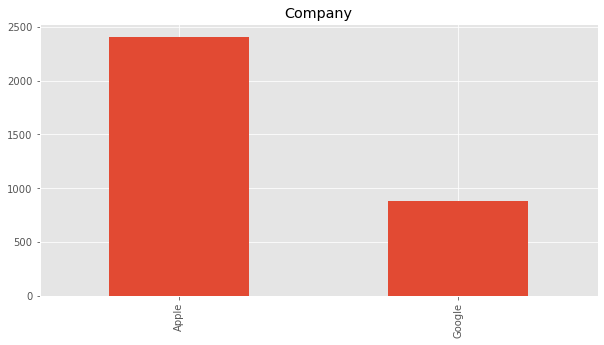

In [15]:
ax = data['Company'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'Company',
         figsize=(10,5))

<AxesSubplot:title={'center':'Sentiment for Apple products'}>

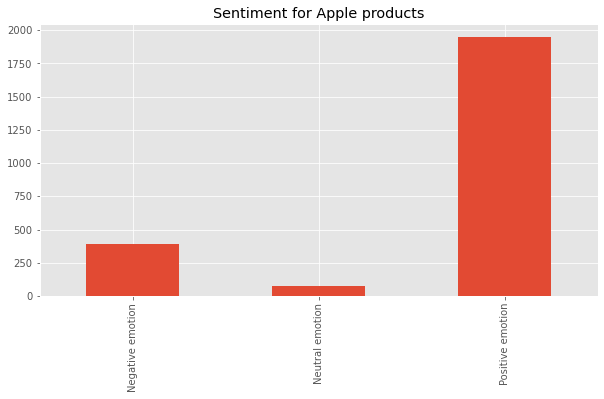

In [29]:
data[data['Company'] == 'Apple']['sentiment'].value_counts().sort_index().plot( \
            kind='bar',
            title = 'Sentiment for Apple products',
            figsize=(10,5))


<AxesSubplot:title={'center':'Sentiment for Google products'}>

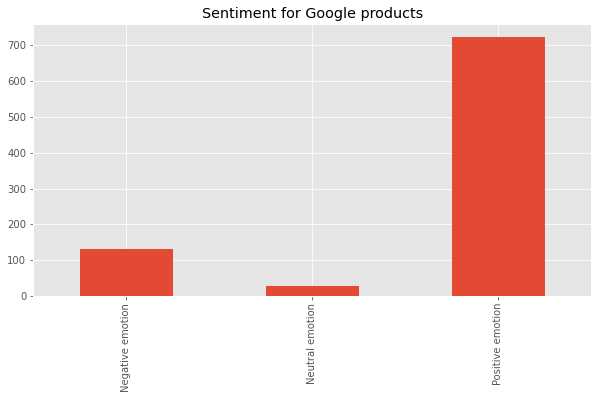

In [31]:
data[data['Company'] == 'Google']['sentiment'].value_counts().sort_index().plot( \
            kind='bar',
            title = 'Sentiment for Google products',
            figsize=(10,5))

In [17]:
ax = data['Sentiment', data['Company'] == 'Apple'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'Sentiment for Apple products',
         figsize=(10,5))

TypeError: '('Sentiment', 0        True
1        True
2        True
3        True
4       False
        ...  
3286     True
3287     True
3288    False
3289     True
3290     True
Name: Company, Length: 3291, dtype: bool)' is an invalid key

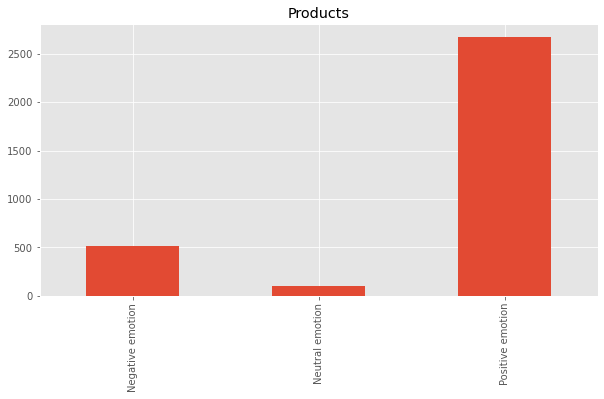

In [13]:
ax = data['sentiment'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'Products',
         figsize=(10,5))

Data is clearly biased towards positive emotion, something to keep in mind

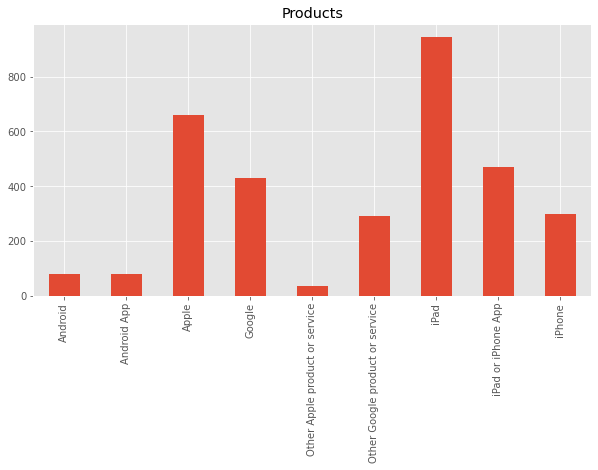

In [14]:
ax = data['product'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'Products',
         figsize=(10,5))

## Basic NLTK preprocessing

In [37]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [38]:
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = tokenizer.tokenize(tweet)
    tweet = [word for word in tweet if word not in stop_words]
    tweet = [stemmer.stem(word) for word in tweet]
    return ' '.join(tweet)

In [39]:
data['preprocessed_tweet'] = data['tweet'].apply(preprocess)

In [40]:
data['preprocessed_tweet']

0       wesley83 3g iphon 3 hrs tweet rise_austin dead...
1       jessede know fludapp awesom ipad iphon app lik...
2                   swonderlin wait ipad 2 also sale sxsw
3        sxsw hope year festiv crashi year iphon app sxsw
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
3286    mention pr guy convinc switch back iphon great...
3287    quot papyrus sort like ipad quot nice lol sxsw...
3288    diller say googl tv quot might run playstat xb...
3289    alway use camera iphon b c imag stabil mode su...
3290                             ipad everywher sxsw link
Name: preprocessed_tweet, Length: 3291, dtype: object

## Model 1

In [32]:
## Make X into a vector
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['preprocessed_tweet'])

In [33]:
## Create my y-axis and Train Test split
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8512898330804249

In [50]:
y_pred = clf.predict(X_test)

In [51]:
cm = confusion_matrix(y_test, y_pred)

## Model 2

In [42]:
mnb = MultinomialNB()

In [43]:
mnb.fit(X_train, y_train)
mnb.score(X_test, y_test)

0.8361153262518968